In [69]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

import sys, platform
print("=== Environment Info ===")
print(f"Python envi    : {sys.executable}")
print(f"Python version : {sys.version.split()[0]}")
print(f"Platform       : {platform.platform()}")
print(f"geopandas      : {gpd.__version__}")
print(f"numpy          : {np.__version__}")
print(f"matplotlib     : {plt.matplotlib.__version__}")
print("========================")


=== Environment Info ===
Python envi    : c:\Users\pc\.conda\envs\geo_env\python.exe
Python version : 3.11.13
Platform       : Windows-10-10.0.22631-SP0
geopandas      : 0.14.4
numpy          : 1.26.4
matplotlib     : 3.10.6


In [70]:
from pathlib import Path

# Set the working directory
wd_main     = Path(r"G:\Shared drives\Wellcome Trust Project Data") 
wd_shp      = wd_main / "1_preprocess" / "UrbanCoolingModel" / "OfficialWorkingInputs" / "AOIs"
dir_ucm_out = wd_main / "2_postprocess_intermediate" / "UCM_official_runs"
figures_dir = wd_main / "3_final" / "UCM_figures"


admin_shapefile = wd_shp / "London_Borough_aoi.shp"  # Administrative boundary (e.g., census tracts)
# Load administrative boundaries
aoi_adm = gpd.read_file(admin_shapefile)

In [71]:
import re
from pathlib import Path

def make_short_name(path, base_dir) -> str:
    # --- normalize inputs ---
    # Unwrap single-element tuple/list like (path,) or [path]
    if isinstance(path, (tuple, list)):
        if len(path) == 1:
            path = path[0]
        else:
            raise TypeError(f"Expected a path, got a {type(path).__name__} with len {len(path)}")
    if isinstance(base_dir, (tuple, list)):
        if len(base_dir) == 1:
            base_dir = base_dir[0]
        else:
            raise TypeError(f"Expected a base_dir path, got a {type(base_dir).__name__} with len {len(base_dir)}")

    path = Path(path)
    base_dir = Path(base_dir)

    # find prefix (the first folder under base_dir, e.g. 'current_lulc' or 'scenario2')
    try:
        prefix = path.relative_to(base_dir).parts[0]
    except Exception:
        # fallback: immediate parent if not under base_dir
        prefix = path.parent.name

    # extract deg/uhi numbers from filename
    m = re.search(r"scenario_([\d.]+)deg_([\d.]+)uhi", path.name)
    if not m:
        return prefix

    deg = str(int(float(m.group(1))))
    uhi = str(int(float(m.group(2))))
    return f"{prefix}_{deg}_{uhi}"


## Data

## Productivity results

### map of baseline

`uhi_results_[Suffix].shp`: A copy of the input vector “Area of Interest” with the following additional fields:

avg_cc    - Average CC value (-).

avg_tmp_v  - Average temperature value (degC).

avg_tmp_an - Average temperature anomaly (degC).

avd_eng_cn - (optional) Avoided energy consumption (kWh or $ if optional energy cost input column was provided in the Energy Consumption Table).

avg_wbgt_v - (optional) Average WBGT (degC).

avg_ltls_v - (optional) Light work productivity loss (%).

avg_hvls_v - (optional) Heavy work productivity loss (%).

In [72]:
# var = "avg_tmp_v"  # average temp
# var = "avg_ltls_v" # light work       # --> no much impact 
var = "avg_hvls_v" # heavy work

dir_prod = dir_ucm_out / 'scenario2' / 'work_and_energy_runs'


# Load the shapefile
f1 = dir_prod / "uhi_results_london_scenario_20.0deg_2.0uhi_66.9hum_energy_productivity.shp"
gdf_base = gpd.read_file(f1)
print(gdf_base.columns.tolist())
# Ensure avg_hvls_v exists and drop missing values
gdf_base = gdf_base.dropna(subset=[var])


# Load the shapefile
f2 = dir_prod / "uhi_results_london_scenario_25.0deg_5.0uhi_45.0hum_energy_productivity.shp"
gdf_new  = gpd.read_file(f2)    # Alternative scenario
gdf_new = gdf_new.dropna(subset=[var])



# Extract suffix
suffix1 = make_short_name(Path(f1), Path(dir_ucm_out) )  
suffix2 = make_short_name(Path(f2), Path(dir_ucm_out) )
suffix_change = f"{suffix1}_VS_{suffix2}"
print(suffix_change)



['NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'ONS_INNER', 'SUB_2009', 'SUB_2006', 'avg_cc', 'avg_tmp_v', 'avg_tmp_an', 'avd_eng_cn', 'avg_wbgt_v', 'avg_ltls_v', 'avg_hvls_v', 'geometry']
scenario2_20_2_VS_scenario2_25_5


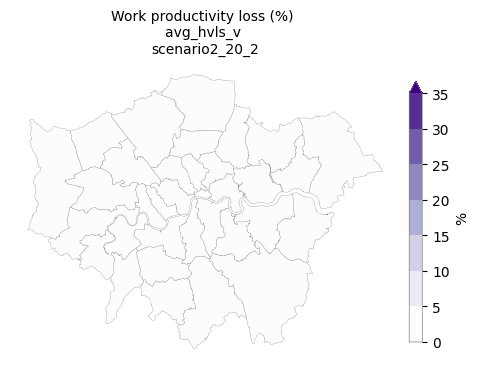

In [73]:


max_value = max(gdf_base[var].max(), gdf_new[var].max())

# Get value range and define equal interval bins
vmin = 0
vmax = np.ceil(max_value / 10) * 10  # Round up to nearest 10
bins = np.arange(vmin, vmax + 10, 5)

# Define colormap (purple gradient, colorblind safe)
cmap = plt.cm.Purples  # Other options: 'BuPu', 'cividis', 'plasma'

# Create a Normalize object for equal interval binning
norm = mcolors.BoundaryNorm(boundaries=bins, ncolors=cmap.N, extend='max')

# Plot
fig, ax = plt.subplots(figsize=(5, 4))
gdf_base.plot(column=var, ax=ax, cmap=cmap, norm=norm, linewidth=0.2, edgecolor="gray")

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # Required for matplotlib < 3.1
cbar = fig.colorbar(sm, ax=ax, ticks=bins, shrink=0.75, pad=0.02)
cbar.set_label("%")
# cbar.outline.set_visible(False)  # This removes the border line
cbar.outline.set_edgecolor("gray")       # Change border color
cbar.outline.set_linewidth(0.5)

# Clean map
ax.set_title(f"Work productivity loss (%) \n{var} \n{suffix1}", fontsize=10)
ax.set_axis_off()
plt.tight_layout()

# Save plot
f = f"productivity_loss_{suffix1}_{var}.png"
output_plot_path = figures_dir / f
plt.savefig(output_plot_path, dpi=300, bbox_inches="tight", transparent=True)

plt.show()


### map of scenario

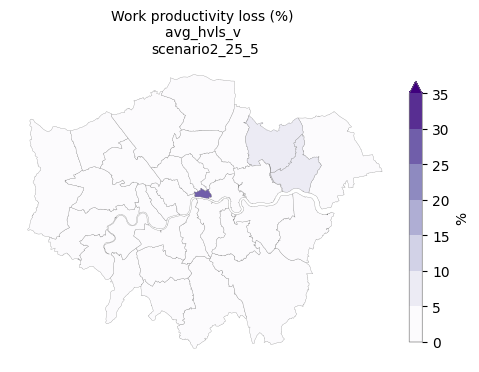

In [74]:
# Plot
fig, ax = plt.subplots(figsize=(5, 4))
gdf_new.plot(column=var, ax=ax, cmap=cmap, norm=norm, linewidth=0.2, edgecolor="gray")

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # Required for matplotlib < 3.1
cbar = fig.colorbar(sm, ax=ax, ticks=bins, shrink=0.75, pad=0.02)
cbar.set_label("%")
# cbar.outline.set_visible(False)  # This removes the border line
cbar.outline.set_edgecolor("gray")       # Change border color
cbar.outline.set_linewidth(0.5)

# Clean map
ax.set_title(f"Work productivity loss (%) \n{var} \n{suffix2}", fontsize=10)
ax.set_axis_off()
plt.tight_layout()

# Save plot
f = f"productivity_loss_{suffix2}_{var}.png"
output_plot_path = figures_dir / f
plt.savefig(output_plot_path, dpi=300, bbox_inches="tight", transparent=True)

plt.show()


### change in pd

max change: 25.0
max change [edited]: 25.0


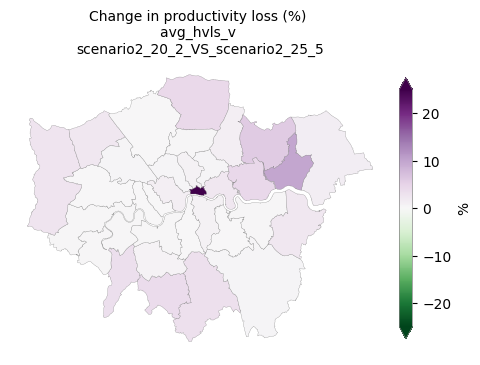

In [75]:

# Ensure same CRS and alignment
gdf_new = gdf_new.to_crs(gdf_base.crs)

# Optional: Merge based on a shared ID column (e.g., 'GEOID' or 'id')
# gdf_merged = gdf_base.merge(gdf_new[["GEOID", "avg_hvls_v"]], on="GEOID", suffixes=("_base", "_new"))

# If geometries match in order (same tract shapes), just copy column
gdf_base["avg_hvls_v_new"] = gdf_new[var].values

# Compute difference
gdf_base["hvls_change"] = gdf_base["avg_hvls_v_new"] - gdf_base[var]

# Filter valid data
gdf_base = gdf_base.dropna(subset=["hvls_change"])

# Define color scale centered at 0
vmax = np.nanmax(np.abs(gdf_base["hvls_change"]))
print(f"max change: {vmax}")

# If vmax == 0 (all values are 0 or NaN), set it to 5
if vmax == 0 or np.isnan(vmax):
    vmax = 5
print(f"max change [edited]: {vmax}")

vmin = -vmax
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot difference map
fig, ax = plt.subplots(figsize=(5, 4))
gdf_base.plot(column="hvls_change", ax=ax, cmap="PRGn_r", norm=norm,
              edgecolor="gray", linewidth=0.2)

# Colorbar
sm = plt.cm.ScalarMappable(cmap="PRGn_r", norm=norm)
sm._A = []
cbar = plt.colorbar(sm, ax=ax, extend = 'both', shrink=0.75, pad=0.02)
cbar.set_label("%")
cbar.outline.set_edgecolor("gray")       # Change border color
cbar.outline.set_linewidth(0.5)

# Final touches
ax.set_title(f"Change in productivity loss (%) \n{var} \n{suffix_change}", fontsize=10)
ax.set_axis_off()
plt.tight_layout()

# Save plot
f = f"productivity_loss_change_{suffix_change}_{var}.png"
output_plot_path = figures_dir / f
plt.savefig(output_plot_path, dpi=300, bbox_inches="tight", transparent=True)

plt.show()


### zoom in map

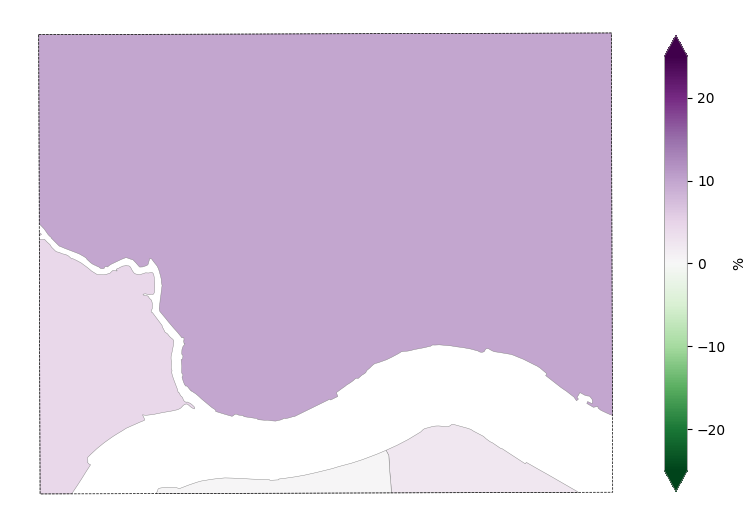

In [76]:
# Load the example region shapefile
f = wd_main / "1_preprocess" / "UrbanCoolingModel" / "zoom in region 1.shp"
zoom_region = gpd.read_file(f).to_crs(gdf_base.crs)

# Clip the difference data to the zoom region
from geopandas.tools import clip
gdf_zoomed = gpd.clip(gdf_base, zoom_region)

# Define color scale again (optional if shared from previous plot)
vmax = np.nanmax(np.abs(gdf_base["hvls_change"]))

# If vmax == 0 (all values are 0 or NaN), set it to 5
if vmax == 0 or np.isnan(vmax):
    vmax = 5

vmin = -vmax
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
cmap = "PRGn_r"

# Plot zoomed-in map
fig, ax = plt.subplots(figsize=(8, 6))
gdf_zoomed.plot(column="hvls_change", cmap=cmap, norm=norm, ax=ax, edgecolor="gray", linewidth=0.3)

# Overlay boundary
zoom_region.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5, linestyle="--", label="Zoom Region")

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = plt.colorbar(sm, ax=ax, extend = 'both', shrink=0.8, pad=0.03)
cbar.set_label("%")
cbar.outline.set_edgecolor("gray")       # Change border color
cbar.outline.set_linewidth(0.5)

# Styling
# ax.set_title("Zoomed-in Change in avg_hvls_v", fontsize=14)
ax.set_axis_off()
plt.tight_layout()

# # Save plot
# f = "productivity_loss_changeZoomIn_" + var + ".png"
# output_plot_path = figures_dir / f
# plt.savefig(output_plot_path, dpi=300, bbox_inches="tight", transparent=True)

plt.show()
